In [1]:
# TODO: run this code if you have not install nltk
# import nltk
# nltk.download()

In [1]:
import os
import io
import sys
import re
import string

import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
import matplotlib.pyplot as plt

from youtube_transcript_api import YouTubeTranscriptApi

from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.probability import FreqDist
from nltk.collocations import *
from nltk import ngrams

from wordcloud import WordCloud, STOPWORDS

scopes = ["https://www.googleapis.com/auth/youtube.readonly"]
# scopes = ["https://www.googleapis.com/auth/youtube.force-ssl"]

# Disable OAuthlib's HTTPS verification when running locally.
# *DO NOT* leave this option enabled in production.
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
client_secrets_file = "client_secret_Thu.json"

# Get credentials and create an API client
flow = google_auth_oauthlib.flow.InstalledAppFlow.from_client_secrets_file(client_secrets_file, scopes)
credentials = flow.run_console()
youtube = googleapiclient.discovery.build(
        api_service_name, api_version, credentials=credentials)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=1058491395494-4qbe4hpnb5akqgcfervr8si3ufe0fgk5.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fyoutube.readonly&state=idRQ5VgykMsYEkqj7GZpRUx5GGwMpg&prompt=consent&access_type=offline
Enter the authorization code: 4/3wE0ce8TTAAwkWhSsE7RDqVZ4lxsWflGoOzpJuPhGIzfUh_2IC_HMKk


In [2]:
# method to get video ids from channel url
# params: url - string to a youtube channel
# return video_ids - list
# raise ValueError when input is invalid channel id
def get_vidids_from_channel(url):
    if not url.startswith("https://www.youtube.com/channel/"):
        raise ValueError("input url not a url")
    else:
        channel_id = url[len("https://www.youtube.com/channel/"):]
    
    # get the playlist of upload videos by the channel
    request = youtube.channels().list(
        part="contentDetails",
        id=channel_id
    )
    response = request.execute()
    if "items" not in response:
        raise ValueError("channel id not valid")
    
    upload_playlist_id = response["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    #print(upload_playlist_id)
    
    # retrieve a list of video ids from upload playlist
    request = youtube.playlistItems().list(
        part="contentDetails",
        maxResults=10,
        playlistId=upload_playlist_id
    )
    response = request.execute()
    
    items = response["items"]
    video_ids = []
    for each in items:
        video_ids.append(each["contentDetails"]["videoId"])
        
    #print(video_ids)
    return video_ids

In [3]:
# method to get transcript from video ids
# params: video_ids - a list of video ids
# the data being written into sample_caption is clean
def get_transcript_from_vidids(video_ids):
    script = []
    for i in range(len(video_ids)):
        script.append(YouTubeTranscriptApi.get_transcript(video_ids[i], languages = ['en']))
    #print(script)

    with open('sample_caption.txt',"w") as filehandle:
        for i in range(len(script)):
            for listitem in script[i]:
                # removing punctuation and numbers and brackets
                filehandle.write(listitem.get('text')+" ")


In [4]:
def clean_caption():
    unclean_file = open('sample_caption.txt','r')
    raw_text = unclean_file.read().lower()
    raw_text = re.sub('\[.*?\]','', raw_text)
    raw_text = re.sub('\(.*?\)','', raw_text)
    raw_text = re.sub('[%s]' % re.escape(string.punctuation), '', raw_text)
    raw_text = re.sub('\w*\d\w','', raw_text)
    raw_text = re.sub('\d+', '', raw_text)
    
    word_tokens = word_tokenize(raw_text)
    stop_words = set(stopwords.words('english'))
    stop_words_extra = ['gon', 'na', 'im']
    for i in range(len(stop_words_extra)):
        stop_words.add(stop_words_extra[i])
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    
    clean_file = open('clean_caption.txt', 'w')
    for each in filtered_sentence:
        clean_file.write(each + " ")
    

    unclean_file.close()
    clean_file.close()

In [21]:
def distribution():
    f = open('clean_caption.txt','r')

    raw = f.read()

    tokens = word_tokenize(raw)

    #create your bigrams
    bgs = ngrams(tokens, 2)

    #compute frequency distribution for all the bigrams in the text
    fdist = FreqDist(bgs)
    
    #sorting the bigram dictionaries
    sort_orders = sorted(fdist.items(), key = lambda x:x[1])
    bg = []
    freq = []
    for item in sort_orders:
        if item[1] >= 10:
            bg.append(item[0][0] + " " + item[0][1])
            freq.append(item[1])
    fig, ax = plt.subplots(figsize=(10,10))
    ax.barh(bg, freq)
    plt.xlabel("Frequency")
    plt.ylabel("2-word phrases")
    plt.show()
    
    #create a trigrams
    tgs = ngrams(tokens,3)
    
    #compute frequency distribution for all the trigrams in the text
    fdist = FreqDist(tgs)
    
    #sorting the trigram dictionaries
    sort_orders = sorted(fdist.items(), key = lambda x:x[1])
    tg = []
    freq = []
    for item in sort_orders:
        if item[1] >= 5:
            tg.append(item[0][0] + " " + item[0][1] + " " + item[0][2])
            freq.append(item[1])
    fig, ax = plt.subplots(figsize=(10,10))
    ax.barh(tg, freq)
    plt.xlabel("Frequency")
    plt.ylabel("3-word phrases")
    plt.show()


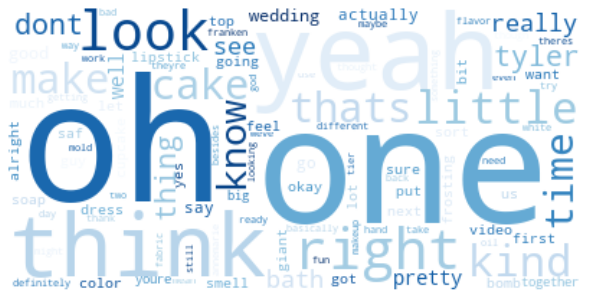

In [48]:
def wordcloud():
    clean_file = open('clean_caption.txt', 'r')
    
    cloud_object = WordCloud(background_color='white',prefer_horizontal=0.9, max_words=100, collocations=False,
                            colormap="Blues")
    cloud = cloud_object.generate(clean_file.read())
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(cloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()
    
    clean_file.close()

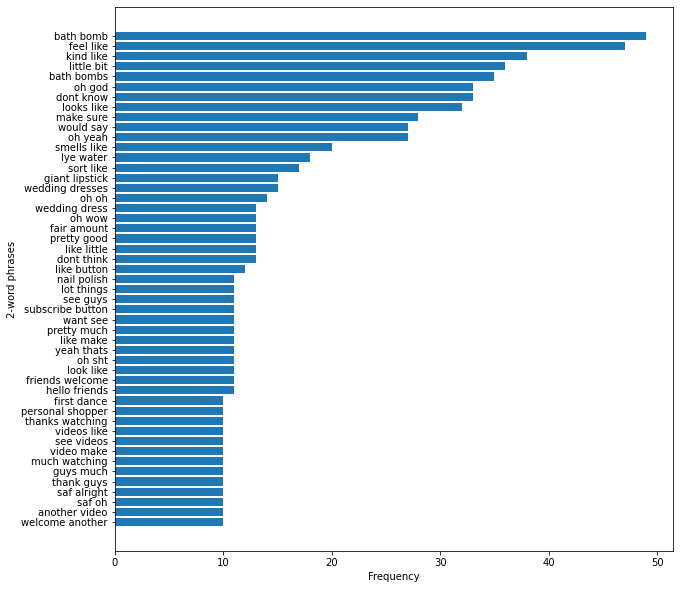

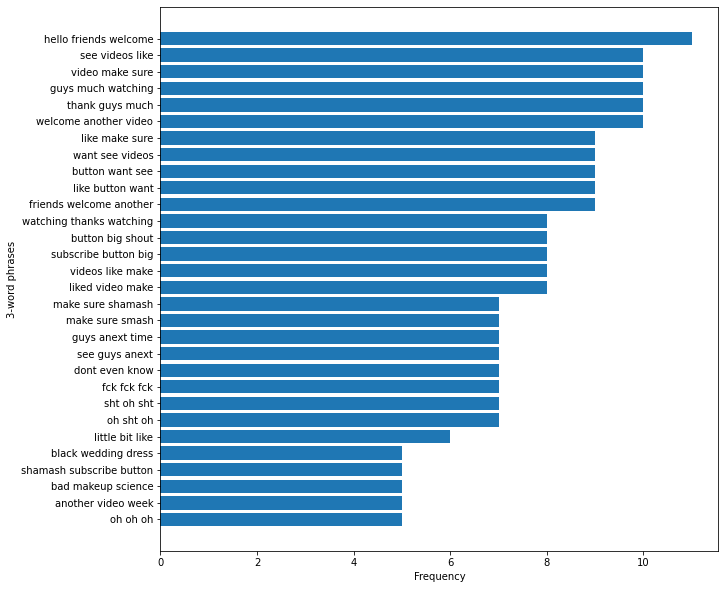

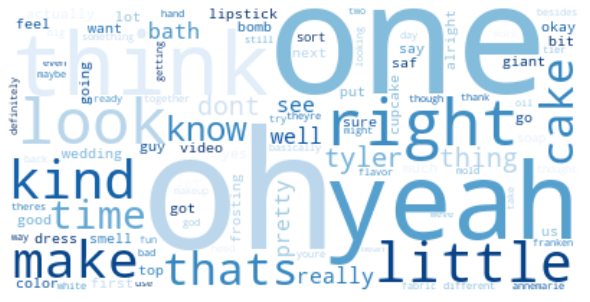

In [49]:
def main():
    vid_ids = get_vidids_from_channel("https://www.youtube.com/channel/UCbAwSkqJ1W_Eg7wr3cp5BUA")
    get_transcript_from_vidids(vid_ids)
    clean_caption()
    distribution()
    wordcloud()
#     get_vidids_from_channel("https://www.youtube.com/channel/UCG7RoGLCkUT7kauOBCRmVEg")
#     get_vidids_from_channel("https://www.youtube.com/channel/UCGCVyTWogzQ4D170BLy2Arw")

if __name__ == "__main__":
    main()